In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -q monai
!pip install -q SimpleITK
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import glob
import monai
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import SimpleITK as sitk
from statistics import mean
from torch.optim import Adam
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import SamModel
import matplotlib.patches as patches
from transformers import SamProcessor
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import threshold, normalize

%matplotlib inline

from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    CopyItemsd,
    LoadImaged,
    CenterSpatialCropd,
    Invertd,
    OneOf,
    Orientationd,
    MapTransform,
    NormalizeIntensityd,
    RandSpatialCropSamplesd,
    CenterSpatialCropd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
    RepeatChanneld,
    ToTensord,
)

In [4]:
import os
os.chdir("/content/drive/MyDrive/skin_data")

In [5]:
import os
path="/content/drive/MyDrive/skin_data"
images_folder_path=os.path.join(path,"train_data")
masks_folder_path=os.path.join(path,"train_label")

In [6]:
!pip install -q monai
!pip install -q SimpleITK


In [7]:
!pip install monai

In [8]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
print(processor)

SamProcessor:
- image_processor: SamImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}



In [9]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        # H, W = ground_truth_map.shape
        # x_min = max(0, x_min - np.random.randint(0, 5))
        # x_max = min(W, x_max + np.random.randint(5, 20))
        # y_min = max(0, y_min - np.random.randint(5, 20))
        # y_max = min(H, y_max + np.random.randint(5, 20))

        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256] # if there is no mask in the array, set bbox to image size


from monai.data import Dataset
from PIL import Image
class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        # Load PNG image and mask using PIL
        image = Image.open(image_path)  # Convert to grayscale
        mask = Image.open(mask_path).convert("L")    # Convert to grayscale

        # Apply transformations
        image = image.resize((256, 256))
        mask = mask.resize((256, 256))

        # Apply get_bounding_box to the mask
        ground_truth_mask = np.array(mask)
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation (ground truth image size is 256x256)
        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))

        return inputs


In [10]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        # H, W = ground_truth_map.shape
        # x_min = max(0, x_min - np.random.randint(0, 5))
        # x_max = min(W, x_max + np.random.randint(5, 20))
        # y_min = max(0, y_min - np.random.randint(5, 20))
        # y_max = min(H, y_max + np.random.randint(5, 20))

        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256] # if there is no mask in the array, set bbox to image size


from monai.data import Dataset
from PIL import Image
class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        # Load PNG image and mask using PIL
        image = Image.open(image_path)  # Convert to grayscale
        mask = Image.open(mask_path).convert("L")    # Convert to grayscale
        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        # Apply transformations
        # image = image.resize((256, 256))
        # mask = mask.resize((256, 256))

        # Apply get_bounding_box to the mask
        ground_truth_mask = np.array(mask)
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation (ground truth image size is 256x256)
        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))

        return inputs


In [85]:
from monai.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        # H, W = ground_truth_map.shape
        # x_min = max(0, x_min - np.random.randint(0, 5))
        # x_max = min(W, x_max + np.random.randint(5, 20))
        # y_min = max(0, y_min - np.random.randint(5, 20))
        # y_max = min(H, y_max + np.random.randint(5, 20))

        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256] # if there is no mask in the array, set bbox to image size

class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        # Load PNG image and mask using PIL
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        mask = Image.open(mask_path).convert("L")    # Convert to grayscale

        # Apply transformations
        image = image.resize((256, 256))
        mask = mask.resize((256, 256))

        # Apply get_bounding_box to the mask
        ground_truth_mask = np.array(mask)
        image = np.array(image)
        print("Transformed Image Shape:", image.shape)
        print("Transformed Mask Shape:", ground_truth_mask.shape)
        image = image.astype(np.uint8)

        # convert the grayscale array to RGB (3 channels)
        array_rgb = np.dstack((image, image, image))

        # convert to PIL image to match the expected input of processor
        image_rgb = Image.fromarray(array_rgb)
        prompt = get_bounding_box(ground_truth_mask)
        # Prepare image and prompt for the model
        inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))
        return inputs


In [86]:
import os
from sklearn.model_selection import train_test_split

# Get the list of file names in the images and masks folders
image_file_names = sorted(os.listdir(images_folder_path))
mask_file_names = sorted(os.listdir(masks_folder_path))

# Create the full paths for each image and mask
image_paths = [os.path.join(images_folder_path, name) for name in image_file_names]
mask_paths = [os.path.join(masks_folder_path, name) for name in mask_file_names]

# Split into training and validation sets with an 80-20 split
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

print("Number of training images:", len(train_image_paths))
print("Number of validation images:", len(val_image_paths))


Number of training images: 720
Number of validation images: 180


In [87]:
train_dataset = SAMDataset(train_image_paths, mask_paths=train_mask_paths, processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = SAMDataset(image_paths=val_image_paths, mask_paths=val_mask_paths, processor=processor)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [88]:
# Print some information about the dataset
print(f"Number of samples in the dataset: {len(train_dataset)}")

Number of samples in the dataset: 720


In [89]:
example = train_dataset[50]

Transformed Image Shape: (256, 256)
Transformed Mask Shape: (256, 256)


In [90]:
example

{'pixel_values': tensor([[[0.6906, 0.6906, 0.6906,  ..., 0.6049, 0.6049, 0.6049],
          [0.6906, 0.6906, 0.6906,  ..., 0.6049, 0.6049, 0.6049],
          [0.6906, 0.6906, 0.6906,  ..., 0.6049, 0.6049, 0.6049],
          ...,
          [0.8961, 0.8961, 0.9132,  ..., 0.7419, 0.7419, 0.7419],
          [0.8961, 0.8961, 0.9132,  ..., 0.7419, 0.7419, 0.7419],
          [0.8961, 0.8961, 0.9132,  ..., 0.7419, 0.7419, 0.7419]],
 
         [[0.8354, 0.8354, 0.8354,  ..., 0.7479, 0.7479, 0.7479],
          [0.8354, 0.8354, 0.8354,  ..., 0.7479, 0.7479, 0.7479],
          [0.8354, 0.8354, 0.8354,  ..., 0.7479, 0.7479, 0.7479],
          ...,
          [1.0455, 1.0455, 1.0630,  ..., 0.8880, 0.8880, 0.8880],
          [1.0455, 1.0455, 1.0630,  ..., 0.8880, 0.8880, 0.8880],
          [1.0455, 1.0455, 1.0630,  ..., 0.8880, 0.8880, 0.8880]],
 
         [[1.0539, 1.0539, 1.0539,  ..., 0.9668, 0.9668, 0.9668],
          [1.0539, 1.0539, 1.0539,  ..., 0.9668, 0.9668, 0.9668],
          [1.0539, 1.053

Transformed Image Shape: (256, 256)
Transformed Mask Shape: (256, 256)
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([256, 256])


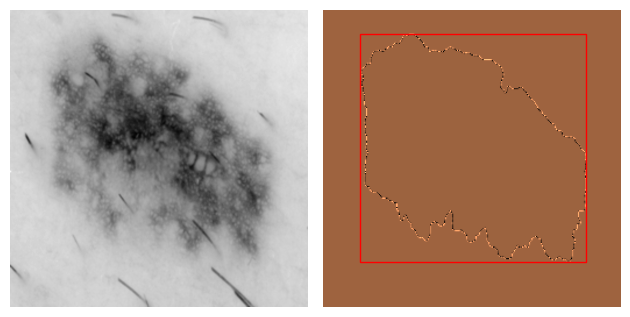

In [91]:
example = train_dataset[1]
for k,v in example.items():
    print(k,v.shape)
# print(example)
xmin, ymin, xmax, ymax = get_bounding_box(example['ground_truth_mask'])

fig, axs = plt.subplots(1, 2)

axs[0].imshow(example['pixel_values'][1], cmap='gray')
axs[0].axis('off')

axs[1].imshow(example['ground_truth_mask'], cmap='copper')

# create a Rectangle patch for the bounding box
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

# add the patch to the second Axes
axs[1].add_patch(rect)

axs[1].axis('off')

plt.tight_layout()
plt.show()

In [92]:
# load the pretrained weights for finetuning
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder (encoder weights are frozen)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [93]:
import torch
# Define the Dice loss function
def dice_loss(logits, targets):
    smooth = 1e-5
    logits = torch.sigmoid(logits)
    intersection = (logits * targets).sum()
    union = logits.sum() + targets.sum() + smooth
    dice = (2 * intersection + smooth) / union
    return 1 - dice

def iou_score(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

In [94]:
import torch
from torch.optim import Adam
from tqdm import tqdm

# Define training loop
num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# Define segmentation loss with sigmoid activation applied to predictions from the model
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Create an arbitrarily large starting validation loss value
best_val_loss = 100.0
best_val_epoch = 0
epoch_train_losses, epoch_val_losses = [], []
train_dice_scores, train_iou_scores = [], []
val_dice_scores, val_iou_scores = [], []

# Set model to train mode for gradient updating
model.train()
for epoch in range(num_epochs):

    # Initialize epoch losses and scores
    train_losses = 0.0
    train_dice_epoch = 0.0
    train_iou_epoch = 0.0

    for i, batch in enumerate(tqdm(train_dataloader)):

        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        print(ground_truth_masks.unsqueeze(1))
        print("hello")
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        print(predicted_masks)
        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()

        # Accumulate loss
        train_losses += loss.item()
                # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
        # Calculate Dice and IoU scores
        dice = dice_loss(medsam_seg, ground_truth_masks)
        iou = iou_score(medsam_seg, ground_truth_masks)
        train_dice_epoch += dice
        train_iou_epoch += iou

    # Create temporary list to record validation losses
    val_losses = 0
    val_dice_epoch = 0.0
    val_iou_epoch = 0.0

    # Set model to eval mode for validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):

            # Forward pass
            outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                            input_boxes=val_batch["input_boxes"].to(device),
                            multimask_output=False)

            # Calculate val loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

            val_losses+=val_loss.item()

            # Calculate Dice and IoU scores
            dice = dice_loss(predicted_val_masks, ground_truth_masks)
            iou = iou_score(predicted_val_masks, ground_truth_masks)
            val_dice_epoch += dice
            val_iou_epoch += iou

        # Apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # Convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        # Save the best weights and record the best performing epoch
        if epoch_loss < best_val_loss:
            torch.save(model.state_dict(), f"best_weights.pth")
            print(f"Model Was Saved! Current Best val loss {best_val_loss}")
            best_val_loss = epoch_loss
            best_val_epoch = epoch
        else:
            print("Model Was Not Saved!")

    print(f'EPOCH: {epoch}')
    print(f'train Loss: {train_losses} train_dice_epoch: {train_dice_epoch} train_iou_epoch: {train_iou_epoch} val_loss: {val_losses} val_dice_epoch: {val_dice_epoch} val_iou_epoch: {val_iou_epoch}')

    epoch_train_losses.append(train_losses)
    epoch_val_losses.append(val_losses)
    train_dice_scores.append(train_dice_epoch)
    train_iou_scores.append(train_iou_epoch)
    val_dice_scores.append(val_dice_epoch)
    val_iou_scores.append(val_iou_epoch)


  0%|          | 0/180 [00:00<?, ?it/s]

Transformed Image Shape: (256, 256)
Transformed Mask Shape: (256, 256)
Transformed Image Shape: (256, 256)
Transformed Mask Shape: (256, 256)
Transformed Image Shape: (256, 256)
Transformed Mask Shape: (256, 256)
Transformed Image Shape: (256, 256)
Transformed Mask Shape: (256, 256)


  1%|          | 1/180 [00:04<12:28,  4.18s/it]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

  1%|          | 2/180 [00:06<09:20,  3.15s/it]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

  2%|▏         | 3/180 [00:08<07:43,  2.62s/it]

tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

  2%|▏         | 4/180 [00:10<07:00,  2.39s/it]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

  3%|▎         | 5/180 [00:12<06:41,  2.29s/it]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

  3%|▎         | 6/180 [00:14<06:30,  2.24s/it]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

  4%|▍         | 7/180 [00:16<06:12,  2.15s/it]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

  4%|▍         | 8/180 [00:19<06:30,  2.27s/it]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

  4%|▍         | 8/180 [00:19<07:04,  2.47s/it]


KeyboardInterrupt: ignored

In [ ]:
ffff

In [ ]:
# define training loop
num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# define optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# define segmentation loss with sigmoid activation applied to predictions from the model
#seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
seg_loss = monai.losses.BinaryDiceLoss(sigmoid=True, squared_pred=True)

# track mean train and validation losses
mean_train_losses, mean_val_losses = [], []

# create an artibarily large starting validation loss value
best_val_loss = 100.0
best_val_epoch = 0

# set model to train mode for gradient updating
model.train()
for epoch in range(num_epochs):

    # create temporary list to record training losses
    epoch_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

        # visualize training predictions every 50 iterations
        if i % 50 == 0:

            # clear jupyter cell output
            clear_output(wait=True)

            fig, axs = plt.subplots(1, 3)
            xmin, ymin, xmax, ymax = get_bounding_box(batch['ground_truth_mask'][0])
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

            axs[0].set_title('input image')
            axs[0].imshow(batch["pixel_values"][0,1], cmap='gray')
            axs[0].axis('off')

            axs[1].set_title('ground truth mask')
            axs[1].imshow(batch['ground_truth_mask'][0], cmap='copper')
            axs[1].add_patch(rect)
            axs[1].axis('off')

            # apply sigmoid
            medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

            axs[2].set_title('predicted mask')
            axs[2].imshow(medsam_seg, cmap='copper')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

    # create temporary list to record validation losses
    val_losses = []

    # set model to eval mode for validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):

            # forward pass
            outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                      input_boxes=val_batch["input_boxes"].to(device),
                      multimask_output=False)

            # calculate val loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

            val_losses.append(val_loss.item())

        # visualize the last validation prediction
        fig, axs = plt.subplots(1, 3)
        xmin, ymin, xmax, ymax = get_bounding_box(val_batch['ground_truth_mask'][0])
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

        axs[0].set_title('input image')
        axs[0].imshow(val_batch["pixel_values"][0,1], cmap='gray')
        axs[0].axis('off')

        axs[1].set_title('ground truth mask')
        axs[1].imshow(val_batch['ground_truth_mask'][0], cmap='copper')
        axs[1].add_patch(rect)
        axs[1].axis('off')

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        axs[2].set_title('predicted mask')
        axs[2].imshow(medsam_seg, cmap='copper')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        # save the best weights and record the best performing epoch
        if mean(val_losses) < best_val_loss:
            torch.save(model.state_dict(), f"best_weights.pth")
            print(f"Model Was Saved! Current Best val loss {best_val_loss}")
            best_val_loss = mean(val_losses)
            best_val_epoch = epoch
        else:
            print("Model Was Not Saved!")

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

    mean_train_losses.append(mean(epoch_losses))
    mean_val_losses.append(mean(val_losses))

In [ ]:
# define training loop
num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# define optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# define segmentation loss with sigmoid activation applied to predictions from the model
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# seg_loss = monai.losses.BinaryDiceLoss(sigmoid=True, squared_pred=True)


# create an artibarily large starting validation loss value
best_val_loss = 100.0
best_val_epoch = 0
mean_train_losses, mean_val_losses = [], []
train_dice_scores, train_iou_scores = [], []
val_dice_scores, val_iou_scores = [], []
# set model to train mode for gradient updating
model.train()
for epoch in range(num_epochs):

    # create temporary list to record training losses
    epoch_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # create temporary list to record validation losses
    val_losses = []

    # set model to eval mode for validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):

            # forward pass
            outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                      input_boxes=val_batch["input_boxes"].to(device),
                      multimask_output=False)

            # calculate val loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

            val_losses.append(val_loss.item())

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)



        # save the best weights and record the best performing epoch
        if mean(val_losses) < best_val_loss:
            torch.save(model.state_dict(), f"best_weights.pth")
            print(f"Model Was Saved! Current Best val loss {best_val_loss}")
            best_val_loss = mean(val_losses)
            best_val_epoch = epoch
        else:
            print("Model Was Not Saved!")

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

    mean_train_losses.append(mean(epoch_losses))
    mean_val_losses.append(mean(val_losses))

In [ ]:
# define training loop
num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# define optimizer
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# define segmentation loss with sigmoid activation applied to predictions from the model
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
seg_loss = monai.losses.BinaryDiceLoss(sigmoid=True, squared_pred=True)

# create an arbitrarily large starting validation loss value
best_val_loss = 100.0
best_val_epoch = 0
mean_train_losses, mean_val_losses = [], []
train_dice_scores, train_iou_scores = [], []
val_dice_scores, val_iou_scores = [], []

# set model to train mode for gradient updating
model.train()
for epoch in range(num_epochs):

    # create temporary list to record training losses
    epoch_losses = []
    for i, batch in enumerate(tqdm(train_dataloader)):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # create temporary list to record validation losses
    val_losses = []

    # set model to eval mode for validation
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader):

            # forward pass
            outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                            input_boxes=val_batch["input_boxes"].to(device),
                            multimask_output=False)

            # calculate val loss
            predicted_val_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

            val_losses.append(val_loss.item())

            # calculate Dice and IoU scores
            dice = monai.metrics.compute_meandice(predicted_val_masks, ground_truth_masks.unsqueeze(1))
            iou = monai.metrics.compute_mean_iou(predicted_val_masks, ground_truth_masks.unsqueeze(1))
            val_dice_scores.append(dice)
            val_iou_scores.append(iou)

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        # save the best weights and record the best performing epoch
        if mean(val_losses) < best_val_loss:
            torch.save(model.state_dict(), f"best_weights.pth")
            print(f"Model Was Saved! Current Best val loss {best_val_loss}")
            best_val_loss = mean(val_losses)
            best_val_epoch = epoch
        else:
            print("Model Was Not Saved!")

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

    mean_train_losses.append(mean(epoch_losses))
    mean_val_losses.append(mean(val_losses))


In [ ]:
# # define training loop
# num_epochs = 50

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# # define optimizer
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# # define segmentation loss with sigmoid activation applied to predictions from the model
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# # track mean train and validation losses
# mean_train_losses, mean_val_losses = [], []

# # create an artibarily large starting validation loss value
# best_val_loss = 100.0
# best_val_epoch = 0

# # set model to train mode for gradient updating
# model.train()
# for epoch in range(num_epochs):

#     # create temporary list to record training losses
#     epoch_losses = []
#     for i, batch in enumerate(tqdm(train_dataloader)):

#         # forward pass
#         outputs = model(pixel_values=batch["pixel_values"].to(device),
#                       input_boxes=batch["input_boxes"].to(device),
#                       multimask_output=False)

#         # compute loss
#         predicted_masks = outputs.pred_masks.squeeze(1)
#         ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#         loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

#         # backward pass (compute gradients of parameters w.r.t. loss)
#         optimizer.zero_grad()
#         loss.backward()

#         # optimize
#         optimizer.step()
#         epoch_losses.append(loss.item())

#         # visualize training predictions every 50 iterations
#         if i % 50 == 0:

#             # clear jupyter cell output
#             clear_output(wait=True)

#             fig, axs = plt.subplots(1, 3)
#             xmin, ymin, xmax, ymax = get_bounding_box(batch['ground_truth_mask'][0])
#             rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

#             axs[0].set_title('input image')
#             axs[0].imshow(batch["pixel_values"][0,1], cmap='gray')
#             axs[0].axis('off')

#             axs[1].set_title('ground truth mask')
#             axs[1].imshow(batch['ground_truth_mask'][0], cmap='copper')
#             axs[1].add_patch(rect)
#             axs[1].axis('off')

#             # apply sigmoid
#             medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

#             # convert soft mask to hard mask
#             medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
#             medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

#             axs[2].set_title('predicted mask')
#             axs[2].imshow(medsam_seg, cmap='copper')
#             axs[2].axis('off')

#             plt.tight_layout()
#             plt.show()

#     # create temporary list to record validation losses
#     val_losses = []

#     # set model to eval mode for validation
#     with torch.no_grad():
#         for val_batch in tqdm(val_dataloader):

#             # forward pass
#             outputs = model(pixel_values=val_batch["pixel_values"].to(device),
#                       input_boxes=val_batch["input_boxes"].to(device),
#                       multimask_output=False)

#             # calculate val loss
#             predicted_val_masks = outputs.pred_masks.squeeze(1)
#             ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#             val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

#             val_losses.append(val_loss.item())

#         # visualize the last validation prediction
#         fig, axs = plt.subplots(1, 3)
#         xmin, ymin, xmax, ymax = get_bounding_box(val_batch['ground_truth_mask'][0])
#         rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

#         axs[0].set_title('input image')
#         axs[0].imshow(val_batch["pixel_values"][0,1], cmap='gray')
#         axs[0].axis('off')

#         axs[1].set_title('ground truth mask')
#         axs[1].imshow(val_batch['ground_truth_mask'][0], cmap='copper')
#         axs[1].add_patch(rect)
#         axs[1].axis('off')

#         # apply sigmoid
#         medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

#         # convert soft mask to hard mask
#         medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
#         medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

#         axs[2].set_title('predicted mask')
#         axs[2].imshow(medsam_seg, cmap='copper')
#         axs[2].axis('off')

#         plt.tight_layout()
#         plt.show()

#         # save the best weights and record the best performing epoch
#         if mean(val_losses) < best_val_loss:
#             torch.save(model.state_dict(), f"best_weights.pth")
#             print(f"Model Was Saved! Current Best val loss {best_val_loss}")
#             best_val_loss = mean(val_losses)
#             best_val_epoch = epoch
#         else:
#             print("Model Was Not Saved!")

#     print(f'EPOCH: {epoch}')
#     print(f'Mean loss: {mean(epoch_losses)}')

#     mean_train_losses.append(mean(epoch_losses))
#     mean_val_losses.append(mean(val_losses))

In [ ]:
# create test dataloader
test_dataset = SAMDataset(image_paths=val_image_paths, mask_paths=val_mask_paths, processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Iteratire through test images
with torch.no_grad():
    for batch in tqdm(test_dataloader):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].cuda(),
                      input_boxes=batch["input_boxes"].cuda(),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().cuda()
#         loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))



        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(batch["pixel_values"][0,1], cmap='gray')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(batch["ground_truth_mask"][0], cmap='copper')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(medsam_seg, cmap='copper')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        break